- 和歌山県を担当
- 本ipynbを含め、分析に際して発生した成果物は https://github.com/kod-y/IndGeo_Mid に保存されています

# データ取得・前処理

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import copy
import japanize_matplotlib

## 和歌山県版産業連関表の前処理

In [2]:
data = pd.read_excel("https://www.pref.wakayama.lg.jp/prefg/020300/sangyo/h27/d00203979_d/fil/t_37.xlsx",
                     index_col=0, skiprows=3)

In [3]:
def combine_columns(data):
    df = data.copy()
    combined_columns = []

    # 複数行にまたがった列名を結合
    for col in df.columns:
        combined_col = ""

        for cell in df[col].iloc[:3]:
            if isinstance(cell, str):
                combined_col += cell

        combined_columns.append(combined_col.strip())

    # 列名を更新
    df.columns = [col.replace(' ', '') for col in combined_columns]

    # 不要な3行を削除する
    df = df.iloc[3:]

    return df

df = combine_columns(data)
df.index = [row[3:] for row in df.index] # 分類番号と半角スペースを落とす
df.drop(df.columns[0], axis=1, inplace=True) # 2列目を落とす
df.head()

,農林漁業,鉱業,飲食料品,繊維製品,パルプ・紙・木製品,化学製品,石油・石炭製品,プラスチック・ゴム製品,窯業・土石製品,鉄鋼,...,在庫純増(G),県内最終需要計(H)=B+～+G,県内需要合計(I)=A+H,移輸出(J),最終需要計(K)=H+J,需要合計(L)=I+J,［控除］移輸入(M),最終需要部門計(N)=K+M,県内生産額(O)=L+M,県内総支出（ＧＤＥ）(P)=N-B
農林漁業,10518,0,35335,289,3751,201,0,104,4,0,...,2066,30595,91446,104718,135313,196164,-53219,82094,142945,81604
鉱業,3,0,40,30,20,1114,433278,5,4701,67020,...,-14907,-15024,565664,1926,-13098,567590,-564219,-577317,3371,-577278
飲食料品,4436,0,35115,62,55,7235,3,1,22,0,...,1523,207731,302802,139892,347623,442694,-240843,106780,201851,100491
繊維製品,1232,13,220,15573,364,243,13,318,85,162,...,763,33413,63689,60092,93505,123781,-58508,34997,65273,34200
パルプ・紙・木製品,5251,8,3903,333,21945,6068,7,455,512,215,...,-1049,5894,87665,57008,62902,144673,-62410,492,82263,-27


In [4]:
# 列名の不要な部分を削除
def remove_suffix(col_name):
    # "("を含む文字列があれば、"("以降を削除して返す
    if "(" in col_name:
        return col_name.split("(")[0]
    else:
        return col_name

# 列名を変更
df.columns = [remove_suffix(col) for col in df.columns]

In [5]:
df.index

Index(['農林漁業', '鉱業', '飲食料品', '繊維製品', 'パルプ・紙・木製品', '化学製品', '石油・石炭製品',
       'プラスチック・ゴム製品', '窯業・土石製品', '鉄鋼', '非鉄金属', '金属製品', 'はん用機械', '生産用機械',
       '業務用機械', '電子部品', '電気機械', '情報通信機器', '輸送機械', 'その他の製造工業製品', '建設',
       '電力・ガス・熱供給', '水道', '廃棄物処理', '商業', '金融・保険', '不動産', '運輸・郵便', '情報通信', '公務',
       '教育・研究', '医療・福祉', '他に分類されない会員制団体', '対事業所サービス', '対個人サービス', '事務用品',
       '分類不明', '内生部門計', '家計外消費支出(行)', '雇用者所得', '営業余剰', '資本減耗引当', '間接税（除関税等）',
       '［控除］経常補助金', '粗付加価値部門計', '県内生産額（ＣＴ）'],
      dtype='object')

In [6]:
df.columns

Index(['農林漁業', '鉱業', '飲食料品', '繊維製品', 'パルプ・紙・木製品', '化学製品', '石油・石炭製品',
       'プラスチック・ゴム製品', '窯業・土石製品', '鉄鋼', '非鉄金属', '金属製品', 'はん用機械', '生産用機械',
       '業務用機械', '電子部品', '電気機械', '情報通信機器', '輸送機械', 'その他の製造工業製品', '建設',
       '電力・ガス・熱供給', '水道', '廃棄物処理', '商業', '金融・保険', '不動産', '運輸・郵便', '情報通信', '公務',
       '教育・研究', '医療・福祉', '他に分類されない会員制団体', '対事業所サービス', '対個人サービス', '事務用品',
       '分類不明', '内生部門計', '家計外消費支出', '民間消費支出', '一般政府消費支出', '県内総固定資本形成（公的）',
       '（民間）', '在庫純増', '県内最終需要計', '県内需要合計', '移輸出', '最終需要計', '需要合計', '［控除］移輸入',
       '最終需要部門計', '県内生産額', '県内総支出（ＧＤＥ）'],
      dtype='object')

In [7]:
df.to_csv("../../data/mid/df_processed.csv")

## 全国版産業連関表の前処理

In [8]:
data_jp = pd.read_excel('https://www.e-stat.go.jp/stat-search/file-download?statInfId=000030137966&fileKind=0',
                        skiprows=2, index_col=1)

In [9]:
# 行・列名がマッチしない部分をpd.renameで揃える
n = 37
Unmatched = data_jp.columns[1:n+1] == df.columns[:n]
rename_dict = {}
for i in range(n):
    if Unmatched[i]: # True
        continue
    else: # False
        rename_dict[data_jp.columns[i+1]] = df.columns[i]

data_jp.rename(index=rename_dict, columns=rename_dict, inplace=True)

In [10]:
data_jp.columns[1:n+1]

Index(['農林漁業', '鉱業', '飲食料品', '繊維製品', 'パルプ・紙・木製品', '化学製品', '石油・石炭製品',
       'プラスチック・ゴム製品', '窯業・土石製品', '鉄鋼', '非鉄金属', '金属製品', 'はん用機械', '生産用機械',
       '業務用機械', '電子部品', '電気機械', '情報通信機器', '輸送機械', 'その他の製造工業製品', '建設',
       '電力・ガス・熱供給', '水道', '廃棄物処理', '商業', '金融・保険', '不動産', '運輸・郵便', '情報通信', '公務',
       '教育・研究', '医療・福祉', '他に分類されない会員制団体', '対事業所サービス', '対個人サービス', '事務用品',
       '分類不明'],
      dtype='object')

In [11]:
data_jp.index[:37]

Index(['農林漁業', '鉱業', '飲食料品', '繊維製品', 'パルプ・紙・木製品', '化学製品', '石油・石炭製品',
       'プラスチック・ゴム製品', '窯業・土石製品', '鉄鋼', '非鉄金属', '金属製品', 'はん用機械', '生産用機械',
       '業務用機械', '電子部品', '電気機械', '情報通信機器', '輸送機械', 'その他の製造工業製品', '建設',
       '電力・ガス・熱供給', '水道', '廃棄物処理', '商業', '金融・保険', '不動産', '運輸・郵便', '情報通信', '公務',
       '教育・研究', '医療・福祉', '他に分類されない会員制団体', '対事業所サービス', '対個人サービス', '事務用品',
       '分類不明'],
      dtype='object')

In [12]:
data_jp.to_csv("../../data/mid/data_jp_processed.csv")

# 分析

## クラス定義

In [13]:
class InputOutputTable:
    def __init__(self, data:pd.DataFrame, n:int):
        self.data = data
        self.n = n
        self.industries = data.index[:n]
        self.A = self.calculate_A()
        self.Mhat = self.calculate_Mhat()
        self.L = self.calculate_L()
        self.G = self.calculate_G()
        self.E = self.calculate_E()
        self.c = self.calculate_c()
        self.x = self.calculate_x()


    def calculate_A(self):
        a = pd.DataFrame(np.zeros((self.n, self.n)), index=self.industries, columns=self.industries)
        for row in self.industries:
            for col in self.industries:
                a.at[row, col] = self.data.at[row, col] / self.data.at[col, '県内生産額']

        return a


    def calculate_Mhat(self):
        mhat = pd.DataFrame(np.zeros((self.n, self.n)), index=self.industries, columns= self.industries)
        for industry in self.industries :
            mhat.at[industry , industry] = - self.data.at[industry, '［控除］移輸入'] / self.data.at[industry, '県内需要合計']

        return mhat


    def calculate_L(self):
        l = np.linalg.inv(np.identity(self.n) - (np.identity(self.n) - self.Mhat.values) @ self.A.values)

        return l


    def calculate_G(self):
        O = pd.DataFrame(np.zeros((self.n, self.n)), index=self.industries, columns= self.industries)
        for row in self.industries:
            for col in self.industries:
                O.at[row, col] = self.data.at[row, col] / self.data.at['県内生産額（ＣＴ）', row]

        g = np.linalg.inv(np.identity(self.n) - O)

        return g


    def calculate_E(self, output:bool=True):
        e = self.data.loc[self.industries, '移輸出']

        return e


    def calculate_c(self):
        C = self.data.loc[self.industries, '県内最終需要計']

        return C


    def calculate_x(self):
        x = self.L @ ((np.identity(self.n) - self.Mhat.values) @ self.c.values + self.E.values)

        return x


    def calculate_linkage(self, option:str):
        if option == 'f': # forward linkage
            return [self.n * np.sum(self.G[i, :]) / np.sum(np.sum(self.G)) for i in range(self.n)]
        elif option == 'b': # backward linkage
            return [self.n * np.sum(self.L[:, i]) / np.sum(np.sum(self.L)) for i in range(self.n)]

In [14]:
IOtable = InputOutputTable(data=df, n=37)

## 各指標の算出

連関指標の計算

In [15]:
n = IOtable.n
industries = IOtable.industries

table = pd.DataFrame([], index=industries)
table.loc[:, '前方連関指標'] = IOtable.calculate_linkage(option='f')
table.loc[:, '後方連関指標'] = IOtable.calculate_linkage(option='b')

total_x = np.sum(IOtable.x)
for i, industry in enumerate(industries):
    A_copy = copy.deepcopy(IOtable.A)
    A_copy.loc[industry, :] = np.zeros(IOtable.n)
    A_copy.loc[:, industry] = np.zeros(IOtable.n)

    Mhat_copy = copy.deepcopy(IOtable.Mhat)
    Mhat_copy.loc[industry, industry] = 0

    E_copy = copy.deepcopy(IOtable.E)
    E_copy.at[industry] = 0

    c_copy = copy.deepcopy(IOtable.c)
    c_copy.at[industry] = 0

    L_copy = np.linalg.inv(np.identity(IOtable.n) - (np.identity(IOtable.n) - Mhat_copy.values) @ A_copy.values)
    x_tilde = L_copy @ ((np.identity(IOtable.n) - Mhat_copy.values) @ c_copy.values + E_copy.values)

    table.at[industry, '総合連関指標'] = 100 * (total_x - IOtable.x[i] - np.sum(x_tilde)) / total_x

純移輸出額

In [16]:
table['純移輸出額'] = df.iloc[:37]['移輸出'] + df.iloc[:37]['［控除］移輸入']

In [17]:
basic_sectors = table[table['純移輸出額'] > 0].index
print(basic_sectors)

Index(['農林漁業', '繊維製品', '化学製品', '石油・石炭製品', '鉄鋼', 'はん用機械', '生産用機械', '電力・ガス・熱供給',
       '教育・研究', '他に分類されない会員制団体'],
      dtype='object')


各産業の純移輸出額の棒グラフ

C:\Users\echo1\AppData\Local\Temp\ipykernel_16784\2801592675.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(frame.index, rotation=90)


Text(0.5, 1.0, '純移輸出額（億円）')

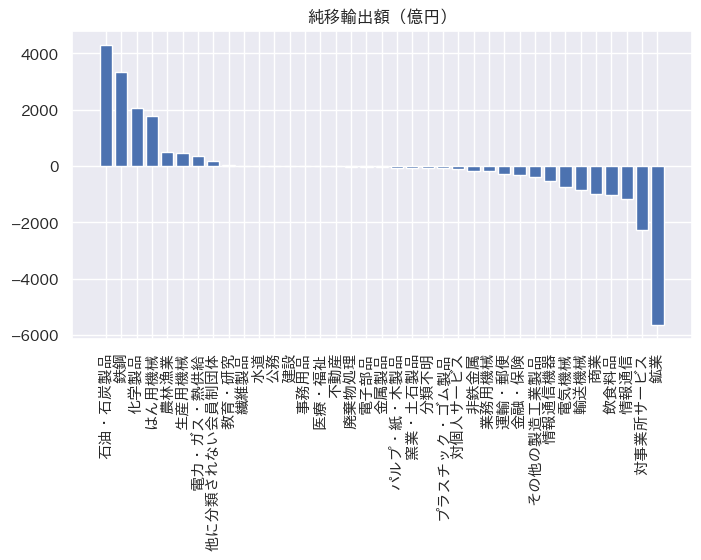

In [18]:
sns.set(font="IPAexGothic")

fig, ax = plt.subplots(figsize = (8, 4))
frame = table['純移輸出額'].sort_values(ascending=False)
ax.bar(frame.index, frame/100)
ax.set_xticklabels(frame.index, rotation=90)
ax.set_title('純移輸出額（億円）')

主要産業の特定

In [19]:
def weighted_average(measure):
    return sum(table[measure] * table['総合連関指標']) / sum(table['総合連関指標'])

key_sectors = table[
    (table.index.isin(basic_sectors))
    & (table['後方連関指標'] >= weighted_average('後方連関指標'))
    & (table['前方連関指標'] >= weighted_average('前方連関指標'))
].index
print(key_sectors)

Index(['鉄鋼'], dtype='object')


In [20]:
print(table[table.index.isin(basic_sectors)].index,
      table[table['後方連関指標'] >= weighted_average('後方連関指標')].index,
      table[table['前方連関指標'] >= weighted_average('前方連関指標')].index,
      sep='\n'
)

Index(['農林漁業', '繊維製品', '化学製品', '石油・石炭製品', '鉄鋼', 'はん用機械', '生産用機械', '電力・ガス・熱供給',
       '教育・研究', '他に分類されない会員制団体'],
      dtype='object')
Index(['鉱業', '窯業・土石製品', '鉄鋼', '金属製品', '生産用機械', '水道', '運輸・郵便', '情報通信', '事務用品',
       '分類不明'],
      dtype='object')
Index(['鉱業', 'パルプ・紙・木製品', 'プラスチック・ゴム製品', '窯業・土石製品', '鉄鋼', '非鉄金属', '金属製品',
       '電子部品', '電気機械', '情報通信機器', '輸送機械', 'その他の製造工業製品', '電力・ガス・熱供給', '金融・保険',
       '運輸・郵便', '情報通信', '対事業所サービス', '事務用品', '分類不明'],
      dtype='object')


特化係数の算出

In [21]:
for industry in industries:
    table.at[industry, '特化係数'] = (
        IOtable.data.at[industry, '県内生産額'] / sum(IOtable.data.loc[industries, '県内生産額'])) / (
            data_jp.at[industry, '国内生産額'] / sum(data_jp.loc[industries, '国内生産額'])
        )

In [22]:
table

,前方連関指標,後方連関指標,総合連関指標,純移輸出額,特化係数
農林漁業,0.150472,0.930784,0.359693,51499,1.517208
鉱業,28.698341,1.073992,0.018872,-562293,0.566648
飲食料品,0.145534,1.001576,0.738596,-100951,0.725537
繊維製品,0.172141,0.936100,0.183403,1584,2.486046
パルプ・紙・木製品,0.280080,1.004792,0.244323,-5402,0.949454
化学製品,0.180360,0.939355,1.055044,205125,2.263335
石油・石炭製品,0.151086,0.819834,0.405383,431220,3.945203
プラスチック・ゴム製品,0.319997,0.930774,0.175874,-7619,0.664968
窯業・土石製品,0.250931,1.077694,0.200162,-5456,0.863624
鉄鋼,0.218646,1.533540,1.140383,334029,3.473025


In [23]:
table.to_csv('../../reports/mid/table.csv')

In [24]:
print(
    weighted_average('前方連関指標'),
    weighted_average('後方連関指標')
)

0.19547451856097237 1.015761843699735


In [25]:
# 各指標の上位5分類を取得
table['純移輸出額'] = table['純移輸出額'].astype(float)

def take_top_5(data:pd.DataFrame, column:str):
    title = "%s上位5分類" % column
    res = table.nlargest(5, column).index
    return title, res

for col in table.columns:
    print(take_top_5(table, col), sep='\n')

('前方連関指標上位5分類', Index(['鉱業', '輸送機械', '非鉄金属', '対事業所サービス', '電子部品'], dtype='object'))
('後方連関指標上位5分類', Index(['分類不明', '鉄鋼', '金属製品', '事務用品', '水道'], dtype='object'))
('総合連関指標上位5分類', Index(['建設', '商業', '医療・福祉', '対個人サービス', '鉄鋼'], dtype='object'))
('純移輸出額上位5分類', Index(['石油・石炭製品', '鉄鋼', '化学製品', 'はん用機械', '農林漁業'], dtype='object'))
('特化係数上位5分類', Index(['石油・石炭製品', '鉄鋼', 'はん用機械', '繊維製品', '化学製品'], dtype='object'))


前方連関指標と後方連関指標の散布図

Text(0, 0.5, '前方連関指標（対数）')

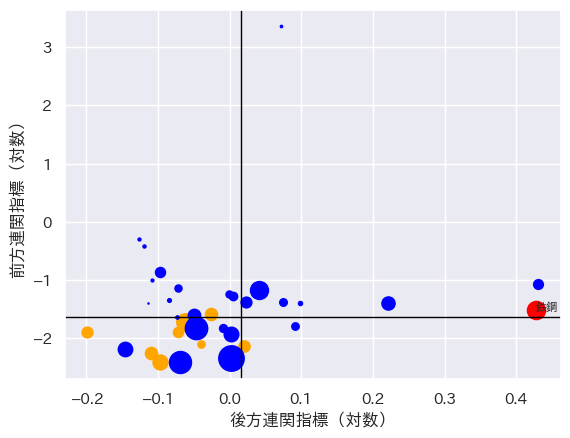

In [26]:
fig, ax = plt.subplots()
colors = pd.Series([
    'red' if industry in key_sectors
    else 'orange' if industry in basic_sectors
    else 'blue' for industry in industries
], index=industries
)

for industry in table.index:
    ax.scatter(x=np.log(table.at[industry, '後方連関指標']),
               y=np.log(table.at[industry, '前方連関指標']),
               s=150*table.at[industry, '総合連関指標'],
               c=colors[industry])
    if industry in key_sectors:
        ax.annotate(industry,
                    (np.log(table.at[industry, '後方連関指標']),
                     np.log(table.at[industry, '前方連関指標'])),
                     size=8)

ax.axvline(np.log(weighted_average('後方連関指標')),
           color='black', linewidth=1)
ax.axhline(np.log(weighted_average('前方連関指標')),
           color='black', linewidth=1)
ax.set_xlabel('後方連関指標（対数）')
ax.set_ylabel('前方連関指標（対数）')

In [27]:
fig.savefig("../../reports/mid/linkages_wakayama.png", bbox_inches='tight')

前方連関指標・後方連関指標が正の分類を表示

Text(0, 0.5, '前方連関指標（対数）')

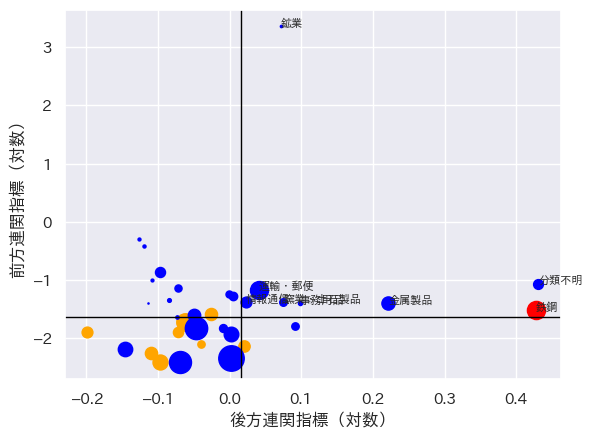

In [28]:
fig, ax = plt.subplots()
colors = pd.Series([
    'red' if industry in key_sectors
    else 'orange' if industry in basic_sectors
    else 'blue' for industry in industries
], index=industries
)

semi_key_sectors = table[
    (table['後方連関指標'] >= weighted_average('後方連関指標'))
    & (table['前方連関指標'] >= weighted_average('前方連関指標'))
].index

for industry in table.index:
    ax.scatter(x=np.log(table.at[industry, '後方連関指標']),
               y=np.log(table.at[industry, '前方連関指標']),
               s=150*table.at[industry, '総合連関指標'],
               c=colors[industry])
    if industry in semi_key_sectors:
        ax.annotate(industry,
                    (np.log(table.at[industry, '後方連関指標']),
                     np.log(table.at[industry, '前方連関指標'])),
                     size=8)

ax.axvline(np.log(weighted_average('後方連関指標')),
           color='black', linewidth=1)
ax.axhline(np.log(weighted_average('前方連関指標')),
           color='black', linewidth=1)
ax.set_xlabel('後方連関指標（対数）')
ax.set_ylabel('前方連関指標（対数）')